In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os

from data_utils import SegItemListCustom, ImageListVertical, SegmentationItemListTwoSourceFoldersProb
from data import data_dirs as data_env, get_label_with_context

from model import (
    LinkNet34,
    accuracy_segmentation, tensorboard_cb, test_showing, jaccard_index_one_class, jaccard_index_zero_class
)

from result_visualization import show_results

from fastai.vision import (
    Learner,
    open_image, open_mask,
    ImageList,
    get_transforms, imagenet_stats,
    ResizeMethod, DatasetType,
    plt,    # matplotlib.pyplot
    nn,     # torch.nn
    optim,  # torch.optim
    Tensor, # torch.Tensor
)
from fastai.callbacks.mem import PeakMemMetric

import warnings
warnings.filterwarnings("ignore")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [8]:
sizes = 128
src = SegmentationItemListTwoSourceFoldersProb(0.5)

src.from_folders(firstFolder=data_env.get_subdir("root"))
src.split_by_folder(first_train="train_red", second_train="train_green",
                    first_val="val_red", second_val="val_green")
src.label_from_func(get_label_with_context, classes=["Sky", "Other"])
src.transform(tfms=get_transforms(), size=sizes, tfm_y=True)
train_data = src.databunch_and_normalized(bs=1, stats=imagenet_stats)

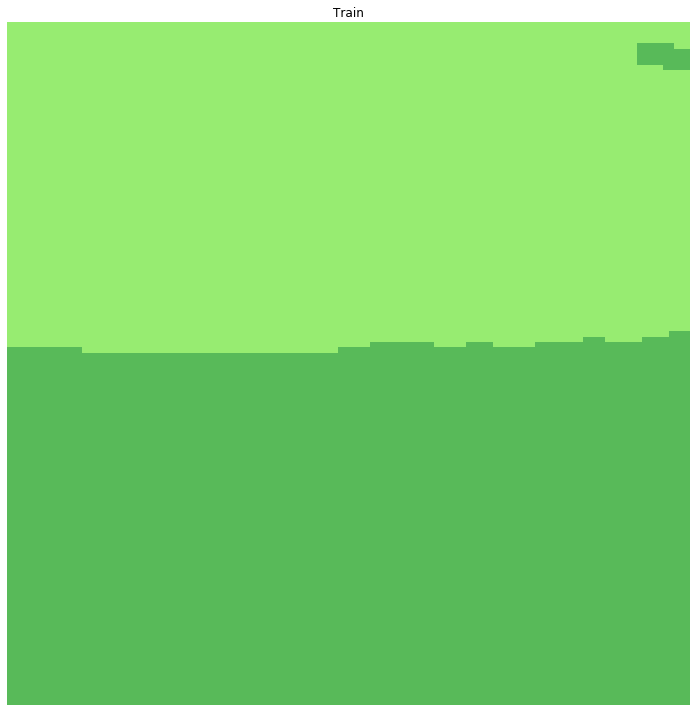

In [12]:
train_data.show_batch(figsize=(15,10), title="Train")

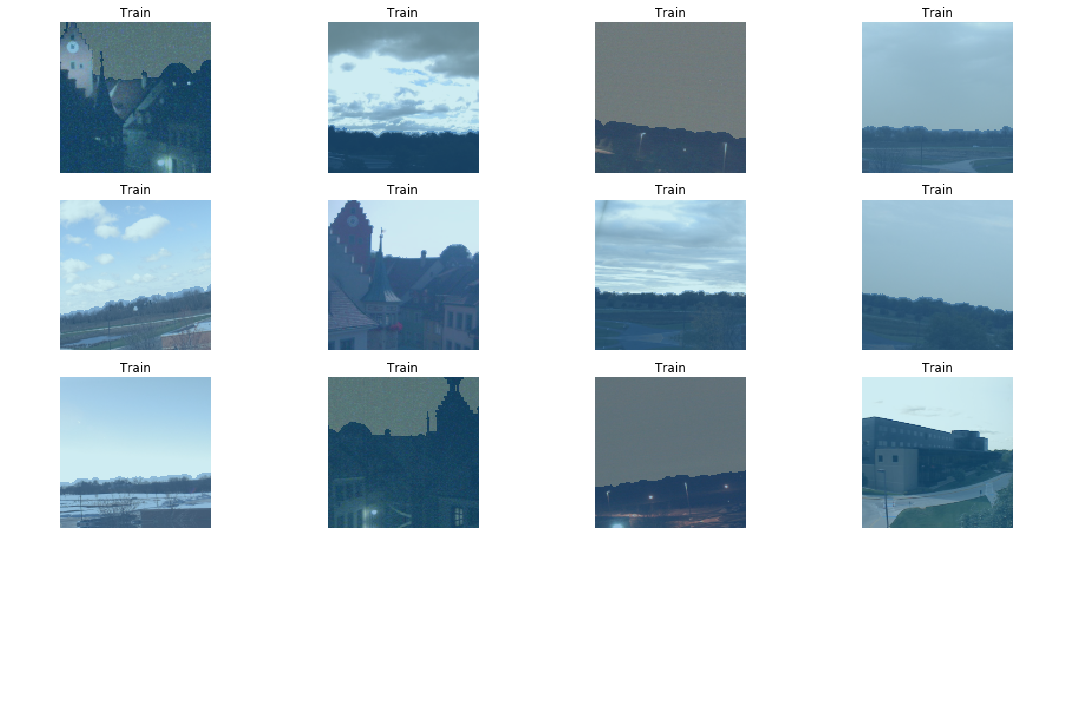

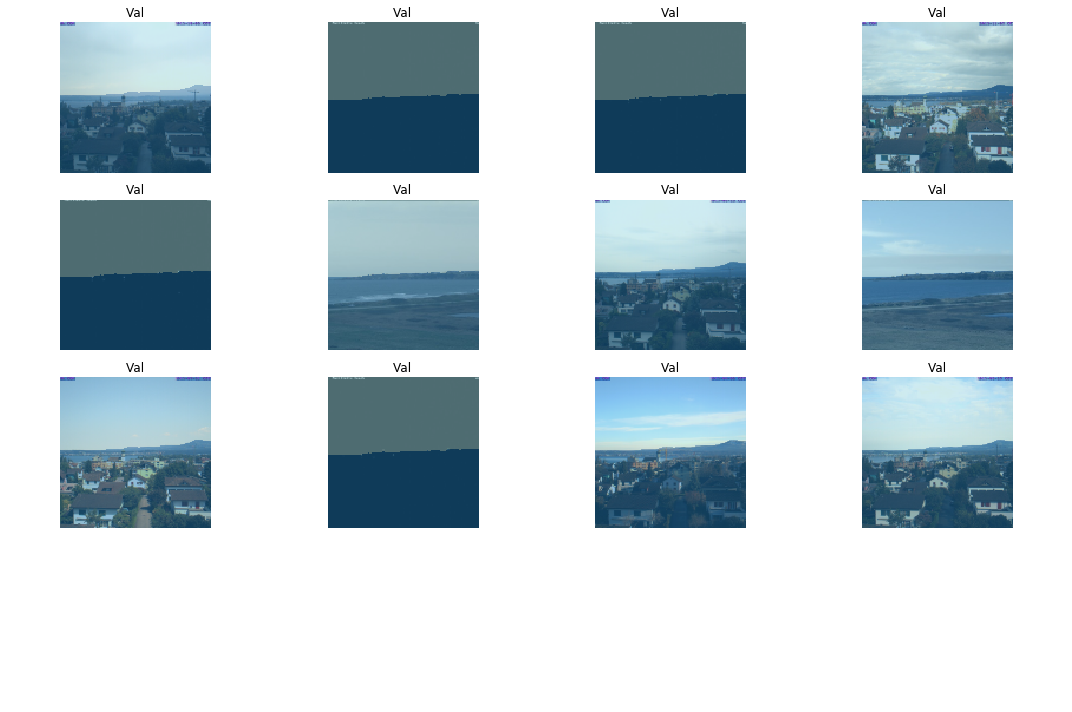

In [6]:
sizes = 128

src = (
    SegItemListCustom
    .from_folder(data_env.get_subdir("root"))
    .split_by_folder("train", "val")
    .label_from_func(get_label_with_context,
                     classes=["Sky", "Other"])
)
train_data = (
    src
    .transform(tfms=get_transforms()
                  , size=sizes, tfm_y=True)
    .databunch(bs=12)
    .normalize(imagenet_stats)
)
classes = train_data.c

train_data.show_batch(figsize=(15,10), title="Train")
train_data.show_batch(figsize=(15,10), title="Val", ds_type=DatasetType.Valid)

In [5]:
model = LinkNet34(num_classes=classes)

learner = Learner(train_data, model)
learner.opt_fn = optim.Adam
learner.loss_fn = nn.BCEWithLogitsLoss()  # pos_weight=Tensor([1])
learner.metrics = [accuracy_segmentation, jaccard_index_one_class, jaccard_index_zero_class]

learner.freeze_to(1)

epoch,train_loss,valid_loss,accuracy_segmentation,jaccard_index_one_class,jaccard_index_zero_class,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E+00
Min loss divided by 10: 3.31E-01


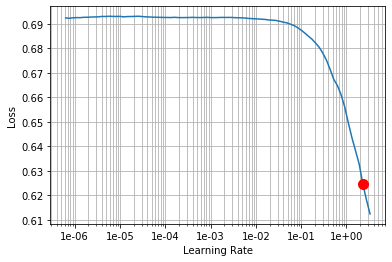

In [6]:
learner.lr_find()
learner.recorder.plot(suggestion=True, show_grid=True)

In [ ]:
# tb_callback = tensorboard_cb("/home/dmitri/Documents/tensorboard_logs", log_name="linknet34_const_full_s128_mlr1e2")

In [ ]:
# learner.fit_one_cycle(50, max_lr=2e-03, callbacks=[tb_callback(learner)])
# learner.fit(50, lr=1e-02, callbacks=[tb_callback(learner)])
# learner.fit(10)
learner.fit_one_cycle(10, max_lr=2e-01)
# learner.recorder.plot_lr(show_moms=True)

In [ ]:
learner.show_results()

In [ ]:
# learner.save("/home/dmitri/Documents/model_weights/linknet34/linknet34_const_full_wghts")
# learner.export("/home/dmitri/Documents/model_weights/linknet34/linknet34_const_full_exp")